In [2]:
# Import libaries and illustris library
import numpy as np
import illustris_python as il
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import gridspec
%matplotlib inline
import random
import subroutines.bins as bf
import subroutines.plot_functions as plot_functions
import subroutines.tree_functions as tf
hubble = 0.704

In [3]:
plt.style.use('default')
mpl.use('pdf')
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['font.size']=15
%load_ext autoreload 
%autoreload 2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# everything in units of h! (h= 0.7)

In [316]:
#load data
snaps=[135,116,103,85]
galData = []
webData = []
for i in snaps:
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    galData.append(np.genfromtxt('../../Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

    # 0:HaloNumber, 1:SubhaloNumber, 2-4:SubhaloPosition x,y,z, 5: Index of nearest critical point, 6: absolute distance to crit., 7-9: nearest critical point coordinates, 
    # 10: Index of nearest filament, 11:absolute distance to filament, 12-14: nearest filament coordinates, 15: cos(theta) 16:sin(theta) 17:cluster(1) fil(0) nothing(-1)
    # 17: cluster=1, filament=0, none=-1
    webData.append(np.genfromtxt('../../Data/WebData/galaxy_web_data.'+str(i)+'.txt'))

galData_ellip = [];
webData_ellip = [];
for i in range (0,4):
    galData_ellip.append(galData[i][maskEllips(i)])
    webData_ellip.append(webData[i][maskEllips(i)])

In [215]:
def maskEllips(whichSnap):
    return (galData[whichSnap][:,14]<0.5);
def maskMass(whichSnap, mass):
    return (galData[whichSnap][:,2]>mass);
def maskWeb(whichSnap, webValue):
    return (webData[whichSnap][:,17]==webValue);

# bins is bin list, value means filament or cluster (0 or 1), mass means mass cutoff, indices are which to bin
def fractions_function(bins_1, bins_2, value, mass = 11, index1=17, index2=17):
    if (mass == 0):
        fractions = [];
        for i in range (0,4):
            fractions.append( bf.bin_frac(webData[i][maskEllips(i)][:,index1],
                                      galData[i][maskEllips(i)][:,index2], bins_1, value)
                            )
    else:
        fractions = [[],[]]
        for i in range (0,4):
            # first mass below variable mass
            fractions[0].append( bf.bin_frac(webData[i][maskEllips(i) & (~maskMass(i,mass))][:,index1],
                                          galData[i][maskEllips(i) & (~maskMass(i,mass))][:,index2], bins_1, value)
                                )
            # then above
            fractions[1].append(bf.bin_frac(webData[i][maskEllips(i) & (maskMass(i,mass))][:,index1],
                                          galData[i][maskEllips(i) & (maskMass(i,mass))][:,index2], bins_2, value)
                                )
    return fractions;

def redshift_fractions(bcluster=1):
    frac_z = np.zeros((2,2,4))
    for i in range (0,4):
        frac_z[0,:,i] = bf.find_frac(webData[i][maskEllips(i) & (~maskMass(i,11))][:,17],bcluster)[:]
        frac_z[1,:,i] = bf.find_frac(webData[i][maskEllips(i) & (maskMass(i,11))][:,17],bcluster)[:]
    return frac_z

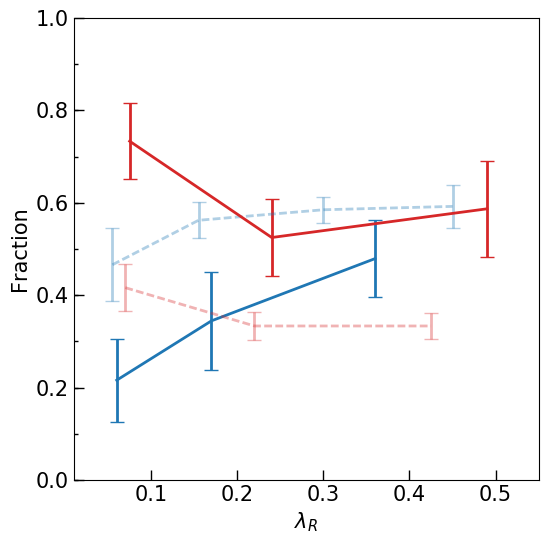

In [300]:
# fraction of ellipcials in filaments (blue) and clusters (red) with mass cutoff at 10^11 M*/M, below that mass dotted, above continuous at z=0
fil_bins_b11 = [0.0,0.11,0.2,0.4,0.5]; fil_bins_a11 = [0.0,0.12,0.22,0.5]; bins_b11 = [0.0,0.14,0.3,0.55]#[0.0,0.13,0.25,0.4,0.5];
bins_a11 = [0.0,0.15,0.33,0.65]#[0.0,0.13,0.25,0.5]#[0.0,0.175,0.25,0.5]
fil_frac = fractions_function(fil_bins_b11,fil_bins_a11,0); clust_frac = fractions_function(bins_b11, bins_a11,1);
fig = plt.figure(figsize=(6, 6));gs=gridspec.GridSpec(1, 1);
for i in [0]:
    ax1 = plt.subplot(gs[0,0], facecolor='white'); #ax2 = plt.subplot(gs[0,1], sharex=ax1, sharey=ax1);
    
    ax1.errorbar(fil_frac[1][i][:,0],fil_frac[1][i][:,1], yerr=fil_frac[1][i][:,2], fmt='-', label='Ellipitc galaxies $M_* >10^{11} M_\odot$', capsize=5,color='C0')
    ax1.errorbar(fil_frac[0][i][:,0],fil_frac[0][i][:,1], yerr=fil_frac[0][i][:,2], fmt='--', label='Ellipitc galaxies $M_* <10^{11} M_\odot$', capsize=5,color='C0',alpha=0.35)
    
    ax1.errorbar(clust_frac[1][i][:,0],clust_frac[1][i][:,1], yerr=clust_frac[1][i][:,2], fmt='-', label='Ellipitc galaxies $M_* >10^{11} M_\odot$', capsize=5,color='C3')
    ax1.errorbar(clust_frac[0][i][:,0],clust_frac[0][i][:,1], yerr=clust_frac[0][i][:,2], fmt='--', label='Ellipitc galaxies $M_* <10^{11} M_\odot$', capsize=5,color='C3',alpha=0.35)
    minor_ticks_y = np.arange(0, 1, 0.1); ax1.set_yticks(minor_ticks_y, minor=True); ax1.yaxis.set_tick_params(which='minor',width=1, length=3, direction='in');
    ax1.xaxis.set_tick_params(width=1, length=7, direction='in');ax1.yaxis.set_tick_params(width=1, length=7, direction='in');
    handles, labels = ax1.get_legend_handles_labels(); handles = [h[0] for h in handles];
ax1.set_xlabel(r'$\lambda_R$'); ax1.set_ylabel('Fraction');ax1.set_ylim([0, 1]);ax1.set_xlim([0.01, 0.55]);


NameError: name 'absolute_clus' is not defined

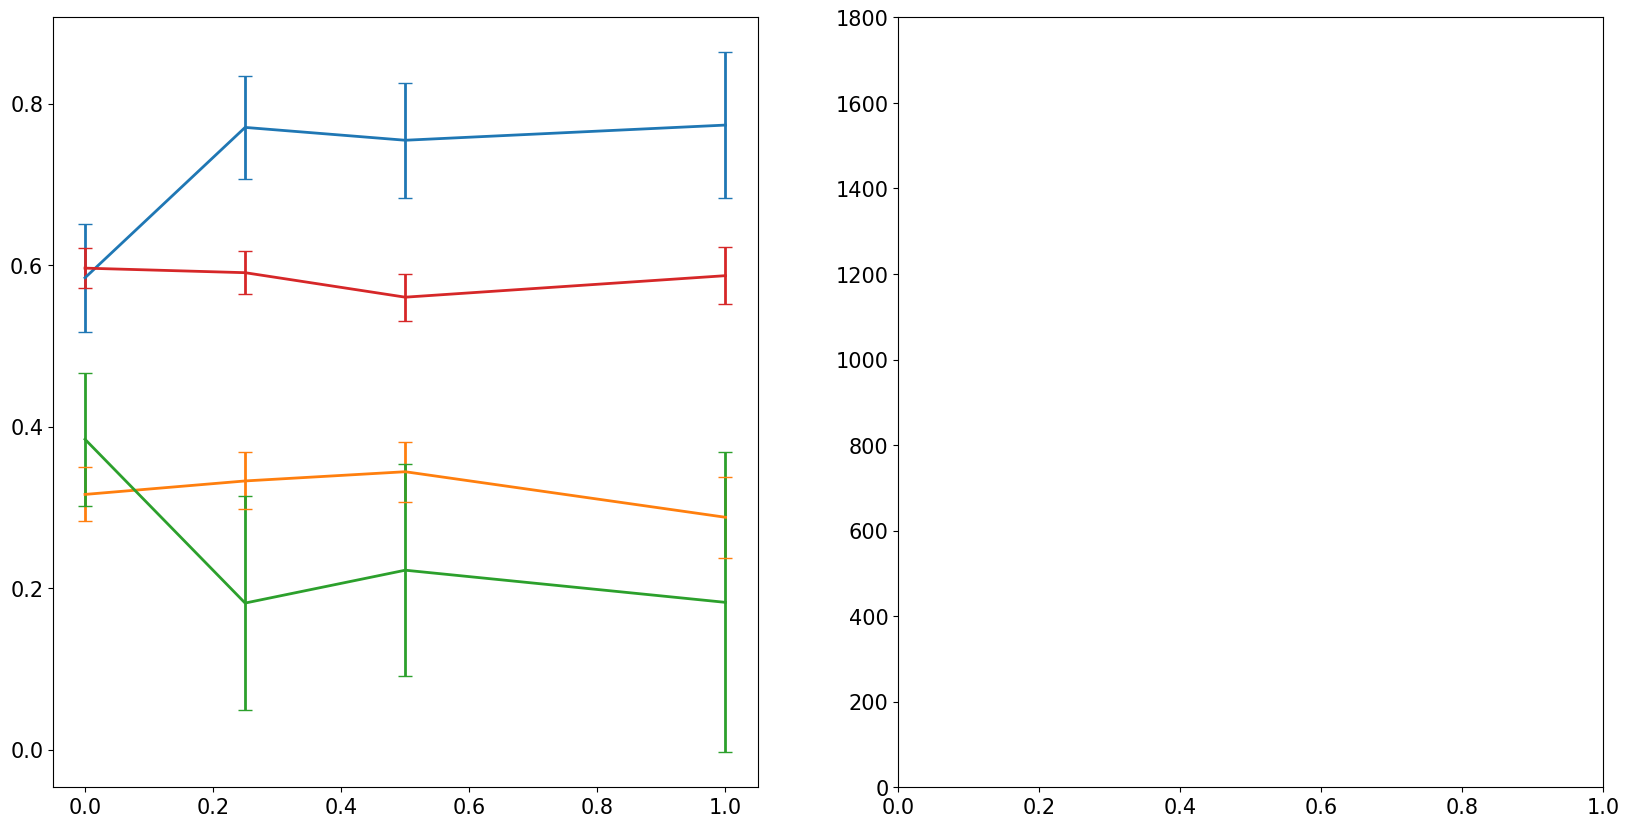

In [208]:
#Ellipitc galaxies fractions and total number per redshift
redshift = [0,0.25,0.50,1]
clust_frac_z = redshift_fractions()
fil_frac_z = redshift_fractions(0)

fig = plt.figure(figsize=(20, 10)); gs=gridspec.GridSpec(1,2); ax3=plt.subplot(gs[0,0]);ax4=plt.subplot(gs[0,1]);

ax3.errorbar(redshift[:], clust_frac_z[1][0][:], yerr=clust_frac_z[1][1][:], fmt='-', label='In clusters $M_* >10^{11} M_\odot$', capsize=5)
ax3.errorbar(redshift[:], clust_frac_z[0][0][:], yerr=clust_frac_z[0][1][:], fmt='-', label='In clusters $M_* <10^{11} M_\odot$', capsize=5)

ax3.errorbar(redshift[:], fil_frac_z[1][0][:], yerr=fil_frac_z[1][1][:], fmt='-', label='In filaments $M_* >10^{11} M_\odot$', capsize=5)
ax3.errorbar(redshift[:], fil_frac_z[0][0][:], yerr=fil_frac_z[0][1][:], fmt='-', label='In filaments $M_* <10^{11} M_\odot$', capsize=5)

#ax4 = ax3.twinx();
ax4.set_ylim([0, 1800]);
ax4.plot(redshift, absolute_clus[1], label='clusters $M_* >10^{11} M_\odot$',linestyle=':'); ax4.plot(redshift, absolute_clus[0], label='clusters $M_* <10^{11} M_\odot$',linestyle=':'); 
ax4.plot(redshift, absolute_fil[1], label='filaments $M_* >10^{11} M_\odot$',linestyle=':'); ax4.plot(redshift, absolute_fil[0], label='filaments $M_* <10^{11} M_\odot$',linestyle=':');

handles, labels = ax3.get_legend_handles_labels(); handles = [h[0] for h in handles];
ax3.legend(handles,labels,loc="upper right"); ax3.set_xlabel('Redshift '); ax3.set_ylabel('Fraction'); ax3.set_ylim([0, 1]);
ax4.set_xlabel('Redshift '); ax4.set_ylabel('Total Number');ax4.legend(handles,labels,loc="upper right");

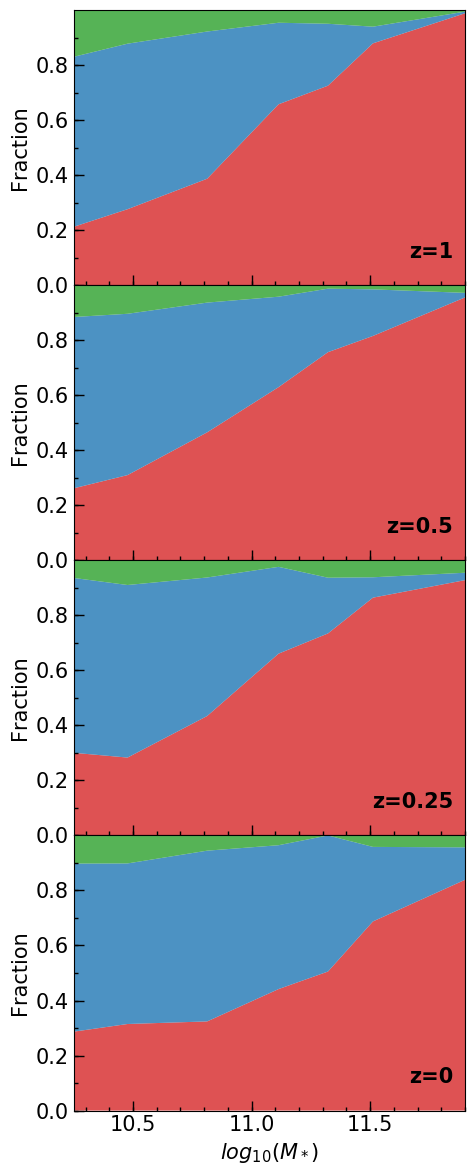

In [529]:
# red is cluster fraction, blue is filaments, green is out, all for !!elliptical galaxies
bins = [1.5,2,4,9,17,25,40,135]; redshift = [0,0.25,0.50,1]
frac_fil = fractions_function(bins, [1], 0, 0, index1=17, index2=2)
frac_clus = fractions_function(bins,[1], 1, 0, index1=17, index2=2)
fig = plt.figure(figsize=(5, 12)); gs=gridspec.GridSpec(4, 1);

for i in [3,2,1,0]:   
    ax = plt.subplot(gs[3-i,0], facecolor='white');
    ax.fill_between(np.log10(frac_fil[i][:,0]*10**10),0,frac_clus[i][:,1],facecolor='C3',alpha=0.8)
    ax.fill_between(np.log10(frac_fil[i][:,0]*10**10),frac_clus[i][:,1],frac_fil[i][:,1]+frac_clus[i][:,1],facecolor='C0',alpha=0.8)
    ax.fill_between(np.log10(frac_fil[i][:,0]*10**10),frac_fil[i][:,1]+frac_clus[i][:,1],1,facecolor='C2',alpha=0.8)
    
    handles, labels = ax1.get_legend_handles_labels(); handles = [h[0] for h in handles];
    ax.text(11.85,0.1, 'z='+str(redshift[i]),fontsize=15, fontweight='bold', ha='right');ax.set_ylabel('Fraction');
    ax.xaxis.set_ticks(np.arange(10, 12, 0.5)); ax.yaxis.set_ticks(np.arange(0, 0.9, 0.2))
    minor_ticks_x = np.arange(10, 12, 0.1); ax.set_xticks(minor_ticks_x, minor=True); ax.xaxis.set_tick_params(which='minor',width=1, length=3, direction='in');                                  
    minor_ticks_y = np.arange(0, 1, 0.1); ax.set_yticks(minor_ticks_y, minor=True); ax.yaxis.set_tick_params(which='minor',width=1, length=3, direction='in');
    ax.set_xlim([10.25, 11.9]);ax.set_ylim([0.0, 1]);
    ax.xaxis.set_tick_params(width=1, length=7, direction='in'); ax.yaxis.set_tick_params(width=1, length=7, direction='in');

ax.xaxis.set_tick_params(width=1, length=7, direction='in'); ax.set_xlabel('$log_{10}(M_*)$'); ax.set_ylim([0.0, 1]);
plt.tight_layout(); plt.subplots_adjust(hspace=0, wspace=.0); plt.show()

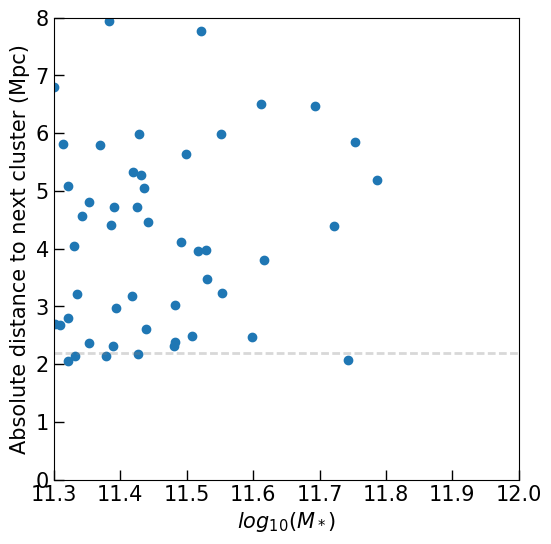

In [292]:
# explore high mass galaxies in filaments
bins = [1.5,2,4,9,17,25,40,55]
redshift = 0
fil_mass_distance = bf.bin_data(galData_ellip[redshift][webData_ellip[redshift][:,17]==0][:,2],webData_ellip[redshift][webData_ellip[redshift][:,17]==0][:,6],bins);

fig = plt.figure(figsize=(6, 6));gs=gridspec.GridSpec(1, 1);
ax1 = plt.subplot(gs[0,0], facecolor='white');
    
ax1.scatter(np.log10(galData_ellip[redshift][webData_ellip[redshift][:,17]==0][:,2]*10**10),webData_ellip[redshift][webData_ellip[redshift][:,17]==0][:,6]/1000, label='Ellipitc galaxies in filaments',color='C0')
#minor_ticks_y = np.arange(0, 1, 0.1); ax1.set_yticks(minor_ticks_y, minor=True); ax1.yaxis.set_tick_params(which='minor',width=1, length=3, direction='in');
ax1.xaxis.set_tick_params(width=1, length=7, direction='in');ax1.yaxis.set_tick_params(width=1, length=7, direction='in');
#handles, labels = ax1.get_legend_handles_labels(); handles = [h[0] for h in handles];
ax1.set_xlabel('$log_{10}(M_*)$'); ax1.set_ylabel('Absolute distance to next cluster (Mpc)');ax1.set_ylim([0,8]);ax1.set_xlim([11.3,12]); ax1.axhline(2.200, color='grey', alpha=0.3, linestyle='--');

# look at filament alignment
log_bin_theta=[];
theta_bins = [[1,3,5,8,25],[]]
for i in [0]:
    log_bin_theta.append(bf.bin_data(galData[i][ maskEllips(i) & (webData[i][:,17]==0)][:,2], 
                                         webData[i][ maskEllips(i) & (webData[i][:,17]==0) ][:,15],theta_bins[i],1)
                         )

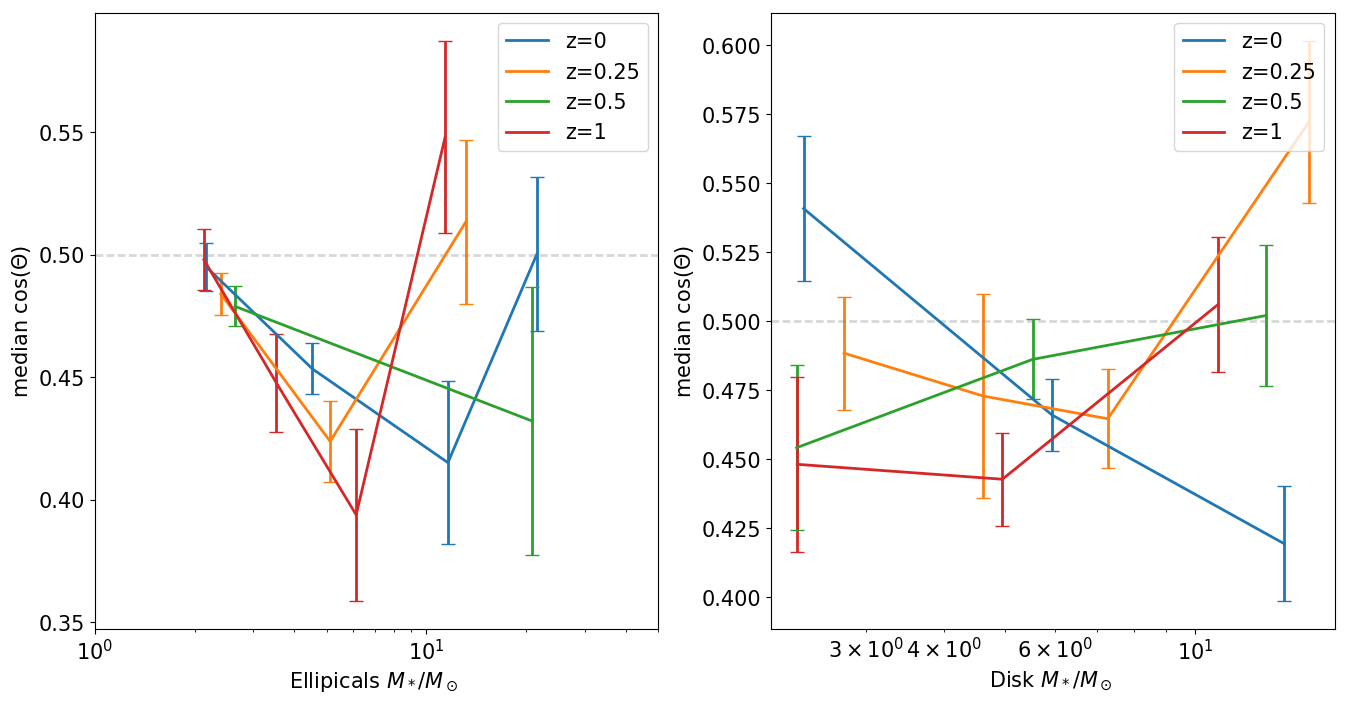

In [10]:
log_bin_theta=[]; theta_bins =[[0,3,10,15,65],[0,4,9,65],[0,15,65],[0,3,5,8,65]];
disk_bin=[]; disk_bins = [[0,3,10,60],[0,4,5,12,60],[0,3,10,60],[0,3,8,60]];

fig = plt.figure(figsize=(16, 8)); gs=gridspec.GridSpec(1,2); ax5=plt.subplot(gs[0,0]);ax6=plt.subplot(gs[0,1]);
for i in [0,1,2,3]:
    log_bin_theta.append(bf.bin_data(galData[i][ maskEllips(i) & (webData[i][:,17]==0)][:,2], abs(webData[i][ maskEllips(i) & (webData[i][:,17]==0) ][:,15]),theta_bins[i],1))
    ax5.errorbar(log_bin_theta[i][:,0], (log_bin_theta[i][:,1]), yerr=log_bin_theta[i][:,3], fmt='-', label='z='+str(redshift[i]), capsize=5)
    
    disk_bin.append(bf.bin_data(galData[i][ (~maskEllips(i)) & (webData[i][:,17]==0)][:,2], abs(webData[i][ (~maskEllips(i)) & (webData[i][:,17]==0) ][:,15]),disk_bins[i],1))
    ax6.errorbar(disk_bin[i][:,0], (disk_bin[i][:,1]), yerr=disk_bin[i][:,3], fmt='-', label='z='+str(redshift[i]), capsize=5)

handles, labels = ax5.get_legend_handles_labels(); handles = [h[0] for h in handles];ax5.set_xlim([1,50])
ax5.legend(handles,labels,loc="upper right"); ax5.set_xlabel('Ellipicals ${M_* }/{ M_\odot }$ '); ax5.set_ylabel('median cos($\Theta$)');ax5.set_xscale('log');ax5.axhline(0.5, color='grey', alpha=0.3, linestyle='--');
ax6.legend(handles,labels,loc="upper right"); ax6.set_xlabel('Disk ${M_* }/{ M_\odot }$ '); ax6.set_ylabel('median cos($\Theta$)');ax6.set_xscale('log');ax6.axhline(0.5, color='grey', alpha=0.3, linestyle='--');

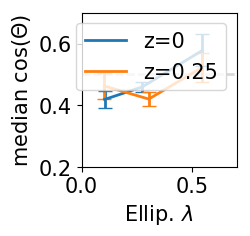

In [12]:
bin_lambda=[]; theta_bins =[[0,0.15,0.5,0.7],[0,0.15,0.5,0.7],[0,0.15,0.5,0.7],[0,0.15,0.5,0.7]]
fig = plt.figure(figsize=(2, 2)); gs=gridspec.GridSpec(1, 1); ax5=plt.subplot(gs[0,0]);
for i in [0,1]:
    bin_lambda.append(bf.bin_data(galData[i][ maskMass(i,5) & maskEllips(i) & (webData[i][:,17]==0)][:,17], abs(webData[i][maskMass(i,5) & maskEllips(i) & (webData[i][:,17]==0) ][:,15]),theta_bins[i],1))
    ax5.errorbar(bin_lambda[i][:,0], (bin_lambda[i][:,1]), yerr=bin_lambda[i][:,3], fmt='-', label='z='+str(redshift[i]), capsize=5)

handles, labels = ax5.get_legend_handles_labels(); handles = [h[0] for h in handles];
ax5.legend(handles,labels,loc="upper right"); ax5.set_xlabel(r'Ellip. $\lambda$'); ax5.set_ylabel('median cos($\Theta$)');ax5.set_xscale('linear');ax5.axhline(0.5, color='grey', alpha=0.3, linestyle='--');
ax5.set_xlim([0,0.7]);ax5.set_ylim([0.2,0.7]);

In [34]:
#load all galaxy data
allgalData = []
for i in range (135,84,-1):
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    allgalData.append(np.genfromtxt('../../Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

allgalData_ellip = []
for i in range(0,51):
    allgalData_ellip.append(
        allgalData[i][allgalData[i][:,14]<0.5]
    )

In [357]:
# input :0-3 for z begin and end, z=0:0
# output: column 0: location in web at start, column 1: location in web at end 2: index of subfind at z_end 3: index of subfind at z_start
def web_evolution(z_begin, z_end, ellipticals = 1):
    if ellipticals == 1:
        data = allgalData_ellip
        webdata = webData_ellip
    else:
        data = allgalData
        webdata = webData
        
    number_map = [0,19,32,50]; start_no = number_map[z_begin]; end_no =  number_map[z_end]  
    a_size= data[start_no][:,0].shape[0];
    output = np.zeros((a_size,4));
    
    for i in range(0, a_size):
        index = tf.find_galaxy(data, start_no, end_no, i);
        output[i, 0] = webdata[z_begin][i,17];
        if index != -1:
            output[i, 1] = webdata[z_end][index,17];
            output[i, 2] = index
            output[i, 3] = i
        else:
            output[i, 1] = np.NAN
            output[i, 2] = np.NAN
    return output    

In [358]:
output = web_evolution(3,0)
no_mov =( (output[:,0] == 1) & (output[:,1] == 1)).sum() + ( (output[:,0] == 0) & (output[:,1] == 0)).sum() +( (output[:,0] == -1) & (output[:,1] == -1)).sum()
fil_to_clus = ( (output[:,0] == 0) & (output[:,1] == 1)).sum()
clus_to_fil = ( (output[:,0] == 1) & (output[:,1] == 0)).sum()
clus_to_none = ( (output[:,0] == 1) & (output[:,1] == -1)).sum()
fil_to_none = ( (output[:,0] == 0) & (output[:,1] == -1)).sum()
none_to_fil = ( (output[:,0] == -1) & (output[:,1] == 0)).sum()
none_to_clus = ( (output[:,0] == -1) & (output[:,1] == 1)).sum()
print(no_mov, fil_to_clus, clus_to_fil, clus_to_none, fil_to_none, none_to_fil, none_to_clus)

399 137 50 12 13 48 36


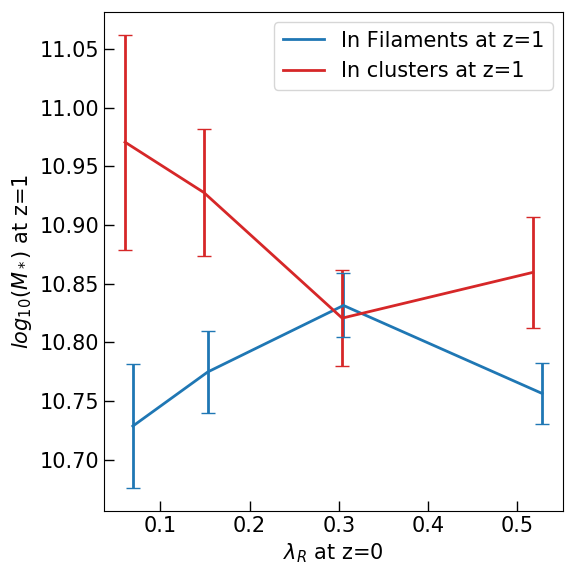

In [504]:
# lambda vs mass for locations in web at z=1
output = web_evolution(3,0); clean_output = output[~np.isnan(output[:,2])].astype('int64'); lambda_output = galData_ellip[0][clean_output[:,2]]
bins1 = [0,.1,0.2,.4,.7];bins2 = [0,.1,0.2,.4,.7];

cluster_at_z1 = output[(output[:,0]==1) & (~np.isnan(output[:,2]))].astype('int64'); fil_at_z1 = output[(output[:,0]==0) & (~np.isnan(output[:,2]))].astype('int64');
clust_frac = bf.bin_data(galData[0][cluster_at_z1[:,2],17], np.log10(galData[3][cluster_at_z1[:,3],2]*10**10), bins1); 
fil_frac   = bf.bin_data(galData[0][fil_at_z1[:,2],17], np.log10(galData[3][fil_at_z1[:,3],2]*10**10), bins2);

fig = plt.figure(figsize=(6, 6));gs=gridspec.GridSpec(1, 1);
ax1 = plt.subplot(gs[0,0], facecolor='white'); #ax2 = plt.subplot(gs[0,1], sharex=ax1, sharey=ax1);
ax1.errorbar(fil_frac[:,0],fil_frac[:,1], yerr=fil_frac[:,3], fmt='-', label='In Filaments at z=1', capsize=5,color='C0')
ax1.errorbar(clust_frac[:,0],clust_frac[:,1], yerr=clust_frac[:,3], fmt='-', label='In clusters at z=1', capsize=5,color='C3')
ax1.xaxis.set_tick_params(width=1, length=7, direction='in');ax1.yaxis.set_tick_params(width=1, length=7, direction='in');
handles, labels = ax1.get_legend_handles_labels(); handles = [h[0] for h in handles];
ax1.set_ylabel('$log_{10}(M_*)$ at z=1'); ax1.set_xlabel(r'$\lambda_R$ at z=0');
ax1.legend(handles,labels,loc="upper right");

plt.tight_layout();

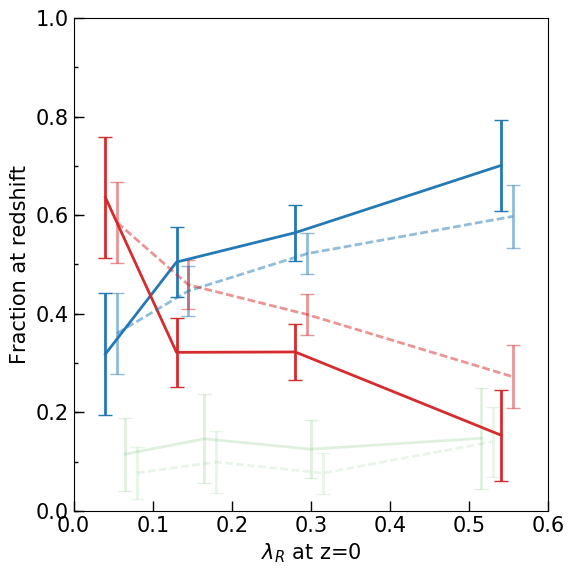

In [588]:
# lambda vs mass for locations in web at z=1
fig = plt.figure(figsize=(6, 6));gs=gridspec.GridSpec(1, 1);
ax1 = plt.subplot(gs[0,0], facecolor='white');
bins1 = np.array([0,0.08,.18,.38,.7]); bins2 = np.array([0,0.08,.18,.38,.7]);bins3 = np.array([0,0.13,0.2,.4,.63]); offset = 0.01
for i in [3,2]:
    offset = +-(0.015*(i-3)); fmt = ['-','--']
    output = web_evolution(i,0); clean_output = output[~np.isnan(output[:,2])].astype('int64'); lambda_output = galData_ellip[0][clean_output[:,2]];
    clust_frac = bf.bin_frac(clean_output[:,0], lambda_output[:,17], bins1+offset, 1); fil_frac= bf.bin_frac(clean_output[:,0], lambda_output[:,17], bins2+offset, 0); void_frac  = bf.bin_frac(clean_output[:,0], lambda_output[:,17], bins3+offset, -1)
    
    ax1.errorbar(fil_frac[:,0],fil_frac[:,1], yerr=fil_frac[:,2], fmt=fmt[i-3], label='Filaments', capsize=5,color='C0', alpha=(i-1)*0.49)
    ax1.errorbar(clust_frac[:,0],clust_frac[:,1], yerr=clust_frac[:,2], fmt=fmt[i-3], label='Clusters', capsize=5,color='C3',alpha=(i-1)*0.49)
    ax1.errorbar(void_frac[:,0],void_frac[:,1], yerr=void_frac[:,2], fmt=fmt[i-3], label='Voids', capsize=5,color='C2', alpha=0.05*i)
    
minor_ticks_y = np.arange(0, 1, 0.1); ax1.set_yticks(minor_ticks_y, minor=True); ax1.yaxis.set_tick_params(which='minor',width=1, length=3, direction='in');
ax1.xaxis.set_tick_params(width=1, length=7, direction='in');ax1.yaxis.set_tick_params(width=1, length=7, direction='in');
ax1.set_ylabel('Fraction at redshift'); ax1.set_xlabel(r'$\lambda_R$ at z=0'); ax1.set_xlim([0,0.6]);ax1.set_ylim([0,1]); 
# ax1.text(0.5,0.7, 'Filaments',fontsize=15, fontweight='bold', ha='right', color='C0'); ax1.text(0.5,0.38, 'Clusters',fontsize=15, fontweight='bold', ha='right', color='C3'); ax1.text(0.5,0.05, 'Voids',fontsize=15, fontweight='bold', ha='right', color='C2', alpha=0.3);
#ax1.text(0.55,0.92, r'$\emdash$ z=1.0',fontsize=15, fontweight='bold', ha='right'); ax1.text(0.55,0.85, r'$\endash\endash$ z=0.5',fontsize=15, fontweight='bold', ha='right'); fig.savefig('../../Plots/Fraction_at_redshift_vs_lambdaz0.pdf', format='pdf')

plt.tight_layout();

270

looking at all halos vvv

In [ ]:
# 0-2: CM position, 3: halo mass, 4: index of nearest filament point, 5: filament absolute distance
# 6: index of nearest crit point, 7: crit absolute distance, 8: bool in cluster, 9: bool in filament
halo_data_file = './data/halo_data_full_sim_v2.txt'
halo_data = np.loadtxt(halo_data_file, comments='#')

# mass versus distance to clust or fil

# 0-2: CM position, 3: halo mass, 4: index of nearest filament point, 5: filament absolute distance
# 6: index of nearest crit point, 7: crit absolute distance, 8: bool in cluster, 9: bool in filament

x  = bf.log_bin_data(halo_data[halo_data[:,8]>0], 3, 7, 15, 1)
x1 = bf.log_bin_data(halo_data[halo_data[:,9]>0], 3, 5, 15, 1)

plt.xscale('log'); plt.yscale('linear');
plt.xlabel('$Total M /M_*$'); plt.ylabel('Distance [ckpc]'); plt.title('Mass functions');

plt.errorbar(x[:,0], x[:,1], xerr=x[:,2], yerr=x[:,3], 
             fmt='o', label = 'Distance to critical points')
plt.errorbar(x1[:,0], x1[:,1], xerr=x1[:,2], yerr=x1[:,3], 
             fmt='o', label = 'Distance to segments')

plt.legend(loc='best')
plt.show()

In [ ]:
# recreate mass density in filaments and clusters graph

# halo_data:
# 0-2: CM position, 3: halo mass, 4: index of nearest filament point, 5: filament absolute distance
# 6: index of nearest crit point, 7: crit absolute distance, 8: bool in cluster, 9: bool in filament
V_ill = (75/0.7)**3

crits_mass_array = halo_data[halo_data[:,8]>0]
segs_mass_array  = halo_data[halo_data[:,9]>0]
void_mass_array  = halo_data[(halo_data[:,8]==0)&(halo_data[:,9]==0)]
total_mass_array = halo_data

#compute mass fraction
total_mass = np.sum(halo_data[:,3]); crits_mass = np.sum(crits_mass_array[:,3]);
segs_mass = np.sum(segs_mass_array[:,3]); voids_mass = np.sum(void_mass_array[:,3]);
print(crits_mass/total_mass, segs_mass/total_mass, voids_mass/total_mass )
# output: 0.433059160264 0.441616986353 0.125323853382

In [ ]:
x =  bf.mass_function(crits_mass_array[:,3], 50)
x1 = bf.mass_function(segs_mass_array[:,3], 50)
x2 = bf.mass_function(total_mass_array[:,3], 50)

plt.plot( x[:,1], x[:,2]/(V_ill * 0.021),'.', label = 'Clusters');
plt.plot( x1[:,1], x1[:,2]/(V_ill * 0.33),'.', label = 'Segments');
plt.plot( x2[:,1], x2[:,2]/(V_ill),'.' , label = 'Total');

plt.xscale('log');plt.yscale('log'); plt.legend(loc='lower left');
plt.xlabel('Mass  $[M/{M_\odot}]$'); plt.ylabel('dn/dM  $[{M_\odot}^{-1} {Mpc}^{-3}]$');
plt.title('Mass function of haloes residing in filaments or clusters \n Abundances in box are rescaled by corresponding volume fractions.')

plt.show()